# Exercise 4

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [52]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train model
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i,data in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        inputs,labels=data
        optimizer.zero_grad()
        
        
        # TODO: run the network
        outputs=model(inputs)

        # TODO: compute negative log likelihood loss
        loss=F.nll_loss(outputs, labels, reduction='sum')
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i%log_interval==0:
            print(f"Epoch {epoch}, Step {i}: Training loss - {loss.item()}")

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [4]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [9]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,100)
        self.fc3=nn.Linear(100,60)
        self.fc4=nn.Linear(60,30)
        self.fc5=nn.Linear(30,10)
        

       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x=x.view(-1,784)
        
        # TODO: run network layers
        x=F.sigmoid(self.fc1(x))
        x=F.sigmoid(self.fc2(x))
        x=F.sigmoid(self.fc3(x))
        x=F.sigmoid(self.fc4(x))
        x=self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output=F.log_softmax(x,dim=1)
        
        return output

In [8]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1=nn.Linear(784,200)
        self.fc2=nn.Linear(200,100)
        self.fc3=nn.Linear(100,60)
        self.fc4=nn.Linear(60,30)
        self.fc5=nn.Linear(30,10)

    def forward(self, x):
        x=x.view(-1,784)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.relu(self.fc4(x))
        x=self.fc5(x)
        output=F.log_softmax(x,dim=1)
        
        return output
        

In [20]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1=nn.Linear(784,200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2=nn.Linear(200,100)
        self.fc3=nn.Linear(100,60)
        self.bn2 = nn.BatchNorm1d(60)
        self.fc4=nn.Linear(60,30)
        self.fc5=nn.Linear(30,10)
        
    def forward(self, x):
        x=x.view(-1,784)
        x=F.relu(self.bn1(self.fc1(x)))
        x=F.relu(self.fc2(x))
        x=F.relu(self.bn2(self.fc3(x)))
        x=F.relu(self.fc4(x))
        x=self.fc5(x)
        output=F.log_softmax(x,dim=1)
        return output
        

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [56]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1=nn.Conv2d(1,32,3)
        self.conv2=nn.Conv2d(32,64,3,2)
        self.fc1=nn.Linear(64*12*12,128)
        self.fc2=nn.Linear(128,10)

        

    def forward(self, x):
        # TODO: run convolutional layers
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, 1)
        
        # TODO: run fully connected layers
        x=F.relu(self.fc1(x))
        x=self.fc2(x)

        # TODO: compute log softmax over the output
        output=F.log_softmax(x,dim=1)

        
        return output

In [57]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1=nn.Conv2d(1,32,3)
        self.bn1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(32,64,3,2)
        self.fc1=nn.Linear(64*12*12,128)
        self.bn2=nn.BatchNorm1d(128)
        self.fc2=nn.Linear(128,10)

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.conv2(x))
        x = x.view(-1, 64*12*12)
        x=F.relu(self.bn2(self.fc1(x)))
        x=self.fc2(x)
        output=F.log_softmax(x,dim=1)
        
        return output

In [72]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1=nn.Conv2d(1,32,3)
        self.bn1=nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(32,64,3)
        self.pool=nn.MaxPool2d((2,2))
        self.fc1=nn.Linear(64*12*12,128)
        self.bn2=nn.BatchNorm1d(128)
        self.fc2=nn.Linear(128,10)

    def forward(self, x):
        x=F.relu(self.bn1(self.conv1(x)))
        x=F.relu(self.pool((self.conv2(x))))
        x = x.view(-1, 64*12*12)
        x=F.relu(self.bn2(self.fc1(x)))
        x=self.fc2(x)
        output=F.log_softmax(x,dim=1)
        return output

### FCNet1

Epoch 1, Step 0: Training loss - 148.65911865234375
Epoch 1, Step 100: Training loss - 117.1141586303711
Epoch 1, Step 200: Training loss - 56.709442138671875
Epoch 1, Step 300: Training loss - 39.63666915893555
Epoch 1, Step 400: Training loss - 32.84435272216797
Epoch 1, Step 500: Training loss - 16.173967361450195
Epoch 1, Step 600: Training loss - 11.916141510009766
Epoch 1, Step 700: Training loss - 10.365280151367188
Epoch 1, Step 800: Training loss - 13.966657638549805
Epoch 1, Step 900: Training loss - 12.649140357971191

Test set: Average loss: 0.2153, Accuracy: 9417/10000 (94.17%)



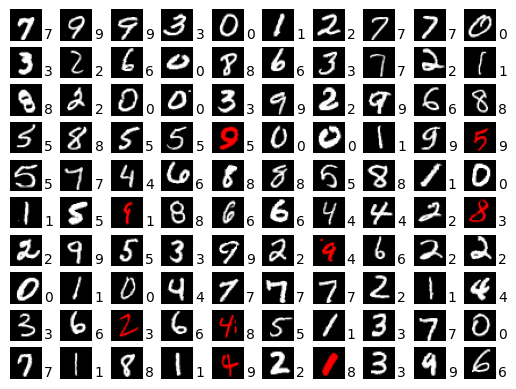

Epoch 2, Step 0: Training loss - 8.622894287109375
Epoch 2, Step 100: Training loss - 10.776066780090332
Epoch 2, Step 200: Training loss - 7.319052696228027
Epoch 2, Step 300: Training loss - 5.780135631561279
Epoch 2, Step 400: Training loss - 3.002822160720825
Epoch 2, Step 500: Training loss - 8.263434410095215
Epoch 2, Step 600: Training loss - 7.288214206695557
Epoch 2, Step 700: Training loss - 8.98306941986084
Epoch 2, Step 800: Training loss - 10.49447250366211
Epoch 2, Step 900: Training loss - 5.056577682495117

Test set: Average loss: 0.1562, Accuracy: 9590/10000 (95.90%)



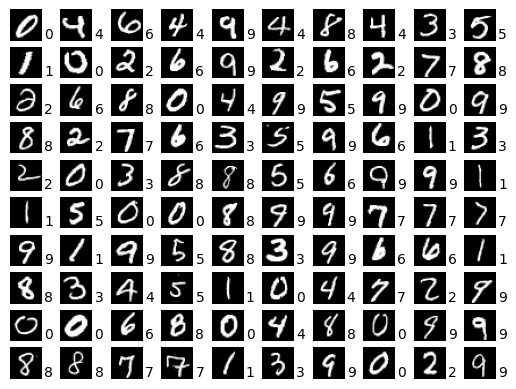

Epoch 3, Step 0: Training loss - 15.857945442199707
Epoch 3, Step 100: Training loss - 1.6205166578292847
Epoch 3, Step 200: Training loss - 6.526590824127197
Epoch 3, Step 300: Training loss - 22.617666244506836
Epoch 3, Step 400: Training loss - 3.907416343688965
Epoch 3, Step 500: Training loss - 7.379068374633789
Epoch 3, Step 600: Training loss - 3.3405027389526367
Epoch 3, Step 700: Training loss - 6.367055416107178
Epoch 3, Step 800: Training loss - 2.1358299255371094
Epoch 3, Step 900: Training loss - 1.5386756658554077

Test set: Average loss: 0.1264, Accuracy: 9649/10000 (96.49%)



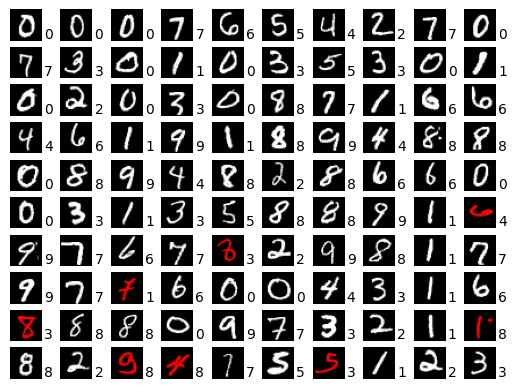

Epoch 4, Step 0: Training loss - 4.904874324798584
Epoch 4, Step 100: Training loss - 10.389681816101074
Epoch 4, Step 200: Training loss - 3.872464895248413
Epoch 4, Step 300: Training loss - 3.3780438899993896
Epoch 4, Step 400: Training loss - 4.193098545074463
Epoch 4, Step 500: Training loss - 7.6243577003479
Epoch 4, Step 600: Training loss - 4.55775260925293
Epoch 4, Step 700: Training loss - 5.184154510498047
Epoch 4, Step 800: Training loss - 0.42185381054878235
Epoch 4, Step 900: Training loss - 3.2604892253875732

Test set: Average loss: 0.1071, Accuracy: 9712/10000 (97.12%)



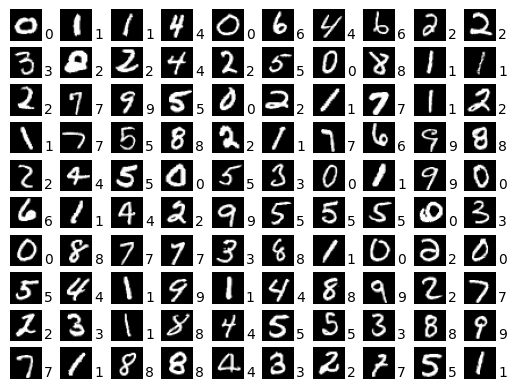

Epoch 5, Step 0: Training loss - 3.3683691024780273
Epoch 5, Step 100: Training loss - 11.079509735107422
Epoch 5, Step 200: Training loss - 7.907217025756836
Epoch 5, Step 300: Training loss - 1.8288638591766357
Epoch 5, Step 400: Training loss - 0.9556782245635986
Epoch 5, Step 500: Training loss - 12.329061508178711
Epoch 5, Step 600: Training loss - 5.20591926574707
Epoch 5, Step 700: Training loss - 9.486556053161621
Epoch 5, Step 800: Training loss - 0.6608281135559082
Epoch 5, Step 900: Training loss - 0.6463579535484314

Test set: Average loss: 0.1060, Accuracy: 9724/10000 (97.24%)



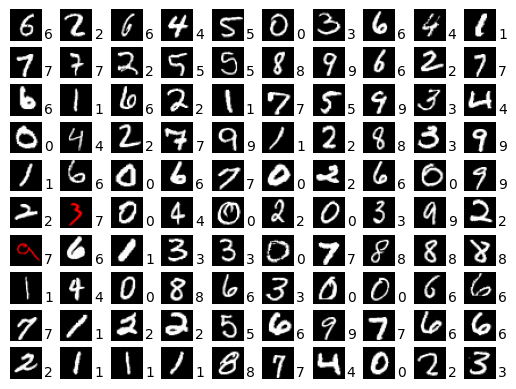

Epoch 6, Step 0: Training loss - 9.34014892578125
Epoch 6, Step 100: Training loss - 6.953220367431641
Epoch 6, Step 200: Training loss - 0.4934830963611603
Epoch 6, Step 300: Training loss - 1.7816437482833862
Epoch 6, Step 400: Training loss - 4.975905895233154
Epoch 6, Step 500: Training loss - 0.441775918006897
Epoch 6, Step 600: Training loss - 7.8278117179870605
Epoch 6, Step 700: Training loss - 1.2043724060058594
Epoch 6, Step 800: Training loss - 7.856383323669434
Epoch 6, Step 900: Training loss - 2.3833556175231934

Test set: Average loss: 0.1016, Accuracy: 9738/10000 (97.38%)



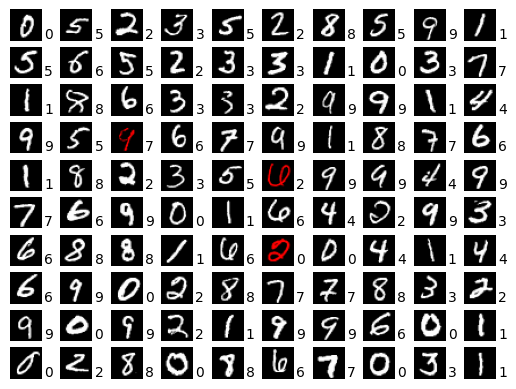

Epoch 7, Step 0: Training loss - 0.7861680388450623
Epoch 7, Step 100: Training loss - 2.613412380218506
Epoch 7, Step 200: Training loss - 3.023508071899414
Epoch 7, Step 300: Training loss - 1.1863994598388672
Epoch 7, Step 400: Training loss - 0.6121866703033447
Epoch 7, Step 500: Training loss - 0.6265111565589905
Epoch 7, Step 600: Training loss - 1.6933672428131104
Epoch 7, Step 700: Training loss - 0.3798534572124481
Epoch 7, Step 800: Training loss - 6.926740646362305
Epoch 7, Step 900: Training loss - 0.6714268922805786

Test set: Average loss: 0.1029, Accuracy: 9740/10000 (97.40%)



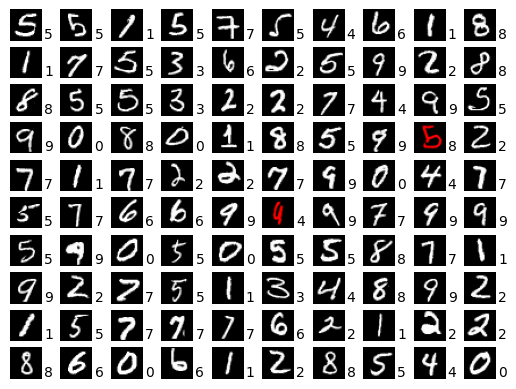

Epoch 8, Step 0: Training loss - 1.466101884841919
Epoch 8, Step 100: Training loss - 1.3237460851669312
Epoch 8, Step 200: Training loss - 0.4377248287200928
Epoch 8, Step 300: Training loss - 5.944291591644287
Epoch 8, Step 400: Training loss - 0.7425059080123901
Epoch 8, Step 500: Training loss - 1.2023967504501343
Epoch 8, Step 600: Training loss - 0.49236559867858887
Epoch 8, Step 700: Training loss - 17.58190155029297
Epoch 8, Step 800: Training loss - 5.6873602867126465
Epoch 8, Step 900: Training loss - 2.9839847087860107

Test set: Average loss: 0.1017, Accuracy: 9743/10000 (97.43%)



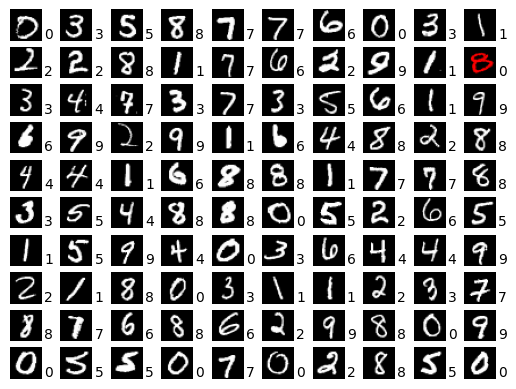

Epoch 9, Step 0: Training loss - 0.9980612397193909
Epoch 9, Step 100: Training loss - 5.020681381225586
Epoch 9, Step 200: Training loss - 7.990067005157471
Epoch 9, Step 300: Training loss - 0.5484586954116821
Epoch 9, Step 400: Training loss - 2.8867392539978027
Epoch 9, Step 500: Training loss - 0.31485050916671753
Epoch 9, Step 600: Training loss - 2.0170724391937256
Epoch 9, Step 700: Training loss - 3.1301541328430176
Epoch 9, Step 800: Training loss - 0.5222944617271423
Epoch 9, Step 900: Training loss - 0.7145716547966003

Test set: Average loss: 0.1025, Accuracy: 9749/10000 (97.49%)



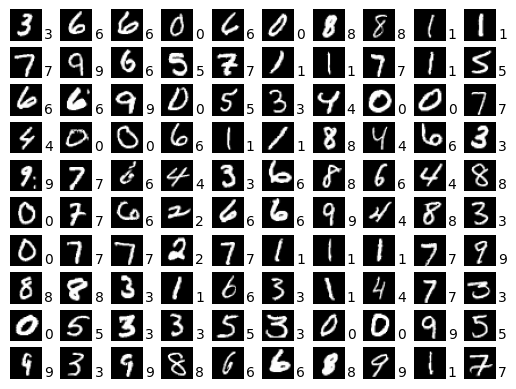

Epoch 10, Step 0: Training loss - 0.2580486834049225
Epoch 10, Step 100: Training loss - 0.2898305058479309
Epoch 10, Step 200: Training loss - 1.1156822443008423
Epoch 10, Step 300: Training loss - 7.052909851074219
Epoch 10, Step 400: Training loss - 1.2261528968811035
Epoch 10, Step 500: Training loss - 1.0766773223876953
Epoch 10, Step 600: Training loss - 0.20724046230316162
Epoch 10, Step 700: Training loss - 0.4018626809120178
Epoch 10, Step 800: Training loss - 0.452269047498703
Epoch 10, Step 900: Training loss - 3.8027069568634033

Test set: Average loss: 0.1038, Accuracy: 9739/10000 (97.39%)



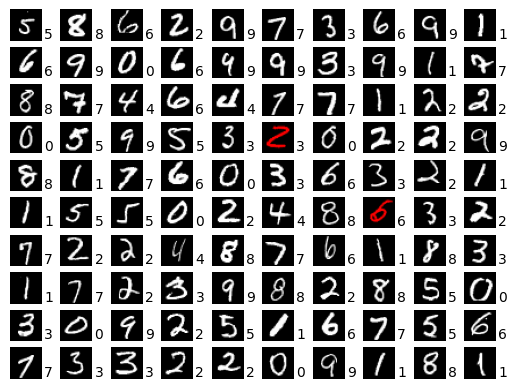

In [17]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### FCNet 2

Epoch 1, Step 0: Training loss - 147.3058624267578
Epoch 1, Step 100: Training loss - 43.978607177734375
Epoch 1, Step 200: Training loss - 16.668184280395508
Epoch 1, Step 300: Training loss - 10.450017929077148
Epoch 1, Step 400: Training loss - 6.55379056930542
Epoch 1, Step 500: Training loss - 12.491878509521484
Epoch 1, Step 600: Training loss - 24.901426315307617
Epoch 1, Step 700: Training loss - 14.69262981414795
Epoch 1, Step 800: Training loss - 3.5582640171051025
Epoch 1, Step 900: Training loss - 20.043743133544922

Test set: Average loss: 0.1258, Accuracy: 9626/10000 (96.26%)



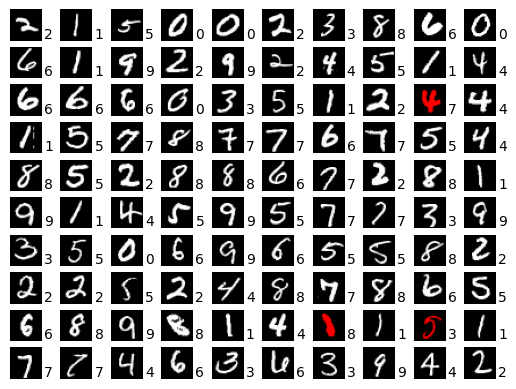

Epoch 2, Step 0: Training loss - 6.394885063171387
Epoch 2, Step 100: Training loss - 12.989471435546875
Epoch 2, Step 200: Training loss - 10.823497772216797
Epoch 2, Step 300: Training loss - 32.122222900390625
Epoch 2, Step 400: Training loss - 13.254565238952637
Epoch 2, Step 500: Training loss - 6.962894439697266
Epoch 2, Step 600: Training loss - 5.94366455078125
Epoch 2, Step 700: Training loss - 5.581813335418701
Epoch 2, Step 800: Training loss - 10.045921325683594
Epoch 2, Step 900: Training loss - 12.511127471923828

Test set: Average loss: 0.0956, Accuracy: 9721/10000 (97.21%)



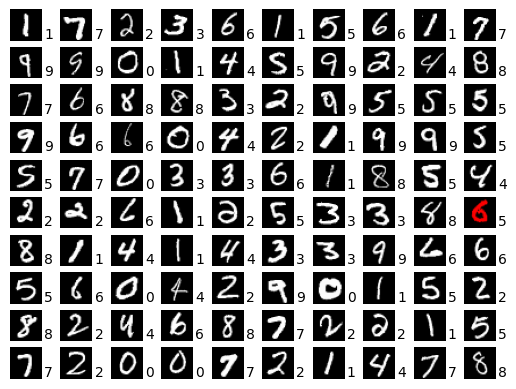

Epoch 3, Step 0: Training loss - 4.62787389755249
Epoch 3, Step 100: Training loss - 3.1279382705688477
Epoch 3, Step 200: Training loss - 0.2785945534706116
Epoch 3, Step 300: Training loss - 3.567997932434082
Epoch 3, Step 400: Training loss - 0.30038875341415405
Epoch 3, Step 500: Training loss - 3.5890016555786133
Epoch 3, Step 600: Training loss - 0.22028224170207977
Epoch 3, Step 700: Training loss - 2.556459665298462
Epoch 3, Step 800: Training loss - 10.831171035766602
Epoch 3, Step 900: Training loss - 12.09917163848877

Test set: Average loss: 0.0867, Accuracy: 9793/10000 (97.93%)



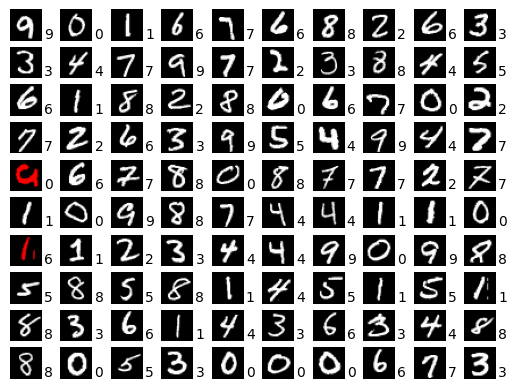

Epoch 4, Step 0: Training loss - 0.378279447555542
Epoch 4, Step 100: Training loss - 5.318312168121338
Epoch 4, Step 200: Training loss - 0.25510162115097046
Epoch 4, Step 300: Training loss - 0.142820805311203
Epoch 4, Step 400: Training loss - 1.3506193161010742
Epoch 4, Step 500: Training loss - 0.18705907464027405
Epoch 4, Step 600: Training loss - 6.1725873947143555
Epoch 4, Step 700: Training loss - 1.175033688545227
Epoch 4, Step 800: Training loss - 0.07123342901468277
Epoch 4, Step 900: Training loss - 2.2073957920074463

Test set: Average loss: 0.0869, Accuracy: 9784/10000 (97.84%)



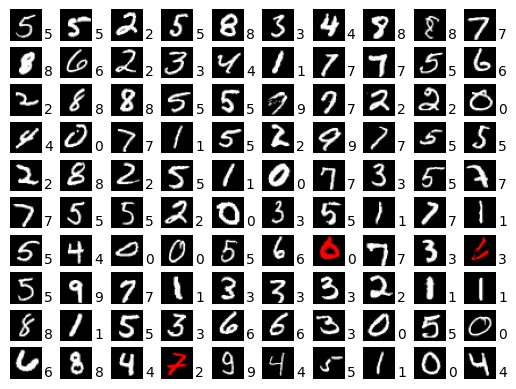

Epoch 5, Step 0: Training loss - 0.10065385699272156
Epoch 5, Step 100: Training loss - 2.728533983230591
Epoch 5, Step 200: Training loss - 0.04000072181224823
Epoch 5, Step 300: Training loss - 0.3735809624195099
Epoch 5, Step 400: Training loss - 4.410185813903809
Epoch 5, Step 500: Training loss - 1.125433325767517
Epoch 5, Step 600: Training loss - 1.9412562847137451
Epoch 5, Step 700: Training loss - 0.4480382800102234
Epoch 5, Step 800: Training loss - 0.7555407285690308
Epoch 5, Step 900: Training loss - 4.152331352233887

Test set: Average loss: 0.0811, Accuracy: 9814/10000 (98.14%)



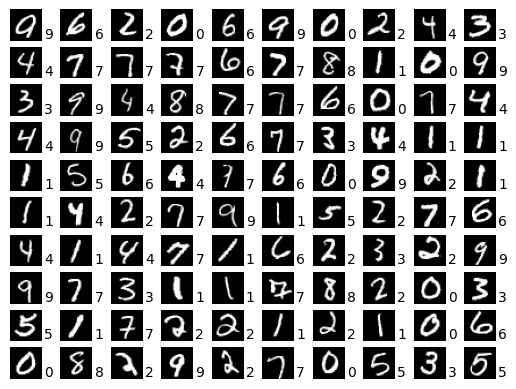

Epoch 6, Step 0: Training loss - 2.72652006149292
Epoch 6, Step 100: Training loss - 0.2363651841878891
Epoch 6, Step 200: Training loss - 0.2993382215499878
Epoch 6, Step 300: Training loss - 0.11394713819026947
Epoch 6, Step 400: Training loss - 0.028924813494086266
Epoch 6, Step 500: Training loss - 0.6026502251625061
Epoch 6, Step 600: Training loss - 3.9955286979675293
Epoch 6, Step 700: Training loss - 0.5674970746040344
Epoch 6, Step 800: Training loss - 0.061961811035871506
Epoch 6, Step 900: Training loss - 0.11919870972633362

Test set: Average loss: 0.0858, Accuracy: 9834/10000 (98.34%)



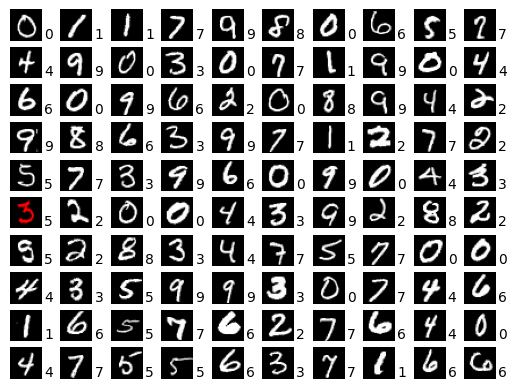

Epoch 7, Step 0: Training loss - 0.023127108812332153
Epoch 7, Step 100: Training loss - 0.5261867642402649
Epoch 7, Step 200: Training loss - 0.105730801820755
Epoch 7, Step 300: Training loss - 0.03719257190823555
Epoch 7, Step 400: Training loss - 0.09012303501367569
Epoch 7, Step 500: Training loss - 0.0055032651871442795
Epoch 7, Step 600: Training loss - 4.073949337005615
Epoch 7, Step 700: Training loss - 1.8968117237091064
Epoch 7, Step 800: Training loss - 0.17437142133712769
Epoch 7, Step 900: Training loss - 1.853851079940796

Test set: Average loss: 0.0913, Accuracy: 9833/10000 (98.33%)



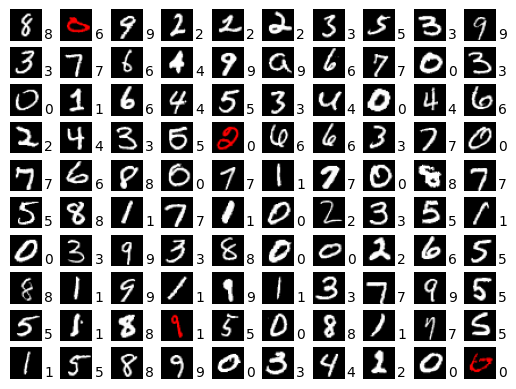

Epoch 8, Step 0: Training loss - 9.17935562133789
Epoch 8, Step 100: Training loss - 0.01690879464149475
Epoch 8, Step 200: Training loss - 0.09082040935754776
Epoch 8, Step 300: Training loss - 0.08666868507862091
Epoch 8, Step 400: Training loss - 0.8383005857467651
Epoch 8, Step 500: Training loss - 0.03993583843111992
Epoch 8, Step 600: Training loss - 0.2203981727361679
Epoch 8, Step 700: Training loss - 0.06341023743152618
Epoch 8, Step 800: Training loss - 0.004123384598642588
Epoch 8, Step 900: Training loss - 0.0084083192050457

Test set: Average loss: 0.0961, Accuracy: 9828/10000 (98.28%)



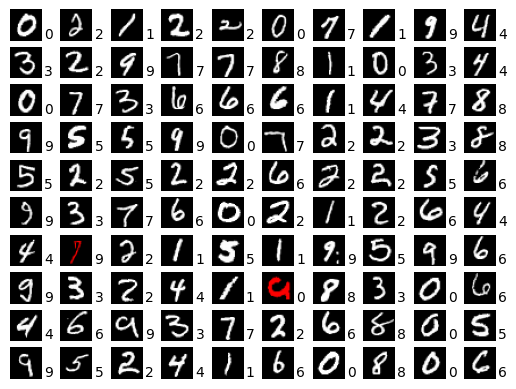

Epoch 9, Step 0: Training loss - 0.33877837657928467
Epoch 9, Step 100: Training loss - 0.12211406230926514
Epoch 9, Step 200: Training loss - 0.012656930834054947
Epoch 9, Step 300: Training loss - 0.003909226041287184
Epoch 9, Step 400: Training loss - 0.06854355335235596
Epoch 9, Step 500: Training loss - 0.15783224999904633
Epoch 9, Step 600: Training loss - 0.01227906346321106
Epoch 9, Step 700: Training loss - 0.019864792004227638
Epoch 9, Step 800: Training loss - 0.13549864292144775
Epoch 9, Step 900: Training loss - 3.4907901287078857

Test set: Average loss: 0.0998, Accuracy: 9834/10000 (98.34%)



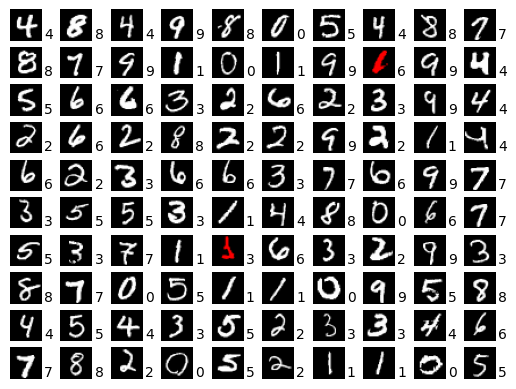

Epoch 10, Step 0: Training loss - 0.2990323305130005
Epoch 10, Step 100: Training loss - 0.021671874448657036
Epoch 10, Step 200: Training loss - 1.2516965866088867
Epoch 10, Step 300: Training loss - 0.2303563505411148
Epoch 10, Step 400: Training loss - 0.04137376695871353
Epoch 10, Step 500: Training loss - 0.2087586522102356
Epoch 10, Step 600: Training loss - 0.5851856470108032
Epoch 10, Step 700: Training loss - 0.01876126229763031
Epoch 10, Step 800: Training loss - 10.960932731628418
Epoch 10, Step 900: Training loss - 0.06229517608880997

Test set: Average loss: 0.1021, Accuracy: 9832/10000 (98.32%)



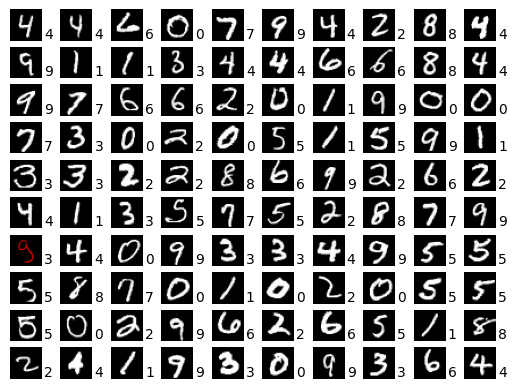

In [18]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### FCNet 3

Epoch 1, Step 0: Training loss - 146.0450439453125
Epoch 1, Step 100: Training loss - 14.925980567932129
Epoch 1, Step 200: Training loss - 26.555967330932617
Epoch 1, Step 300: Training loss - 19.68900489807129
Epoch 1, Step 400: Training loss - 4.924287796020508
Epoch 1, Step 500: Training loss - 32.65747833251953
Epoch 1, Step 600: Training loss - 2.3796043395996094
Epoch 1, Step 700: Training loss - 19.46969223022461
Epoch 1, Step 800: Training loss - 12.273216247558594
Epoch 1, Step 900: Training loss - 3.6114494800567627

Test set: Average loss: 0.1155, Accuracy: 9638/10000 (96.38%)



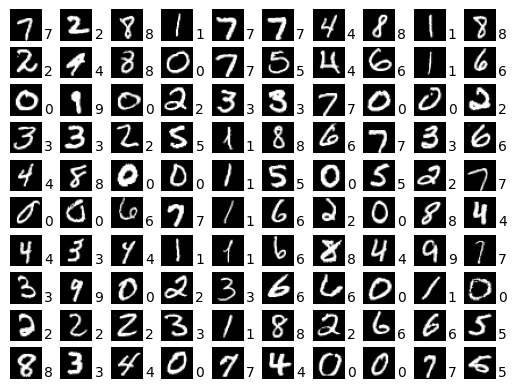

Epoch 2, Step 0: Training loss - 4.412290573120117
Epoch 2, Step 100: Training loss - 12.083795547485352
Epoch 2, Step 200: Training loss - 0.9401530027389526
Epoch 2, Step 300: Training loss - 1.3531701564788818
Epoch 2, Step 400: Training loss - 6.9235734939575195
Epoch 2, Step 500: Training loss - 16.89523696899414
Epoch 2, Step 600: Training loss - 0.33651646971702576
Epoch 2, Step 700: Training loss - 10.225044250488281
Epoch 2, Step 800: Training loss - 3.683231830596924
Epoch 2, Step 900: Training loss - 6.214478015899658

Test set: Average loss: 0.0760, Accuracy: 9764/10000 (97.64%)



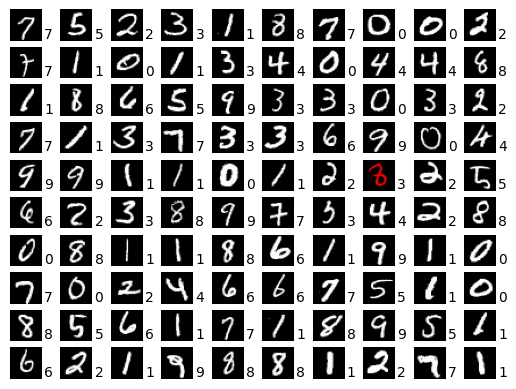

Epoch 3, Step 0: Training loss - 10.179476737976074
Epoch 3, Step 100: Training loss - 0.8035812377929688
Epoch 3, Step 200: Training loss - 4.967766761779785
Epoch 3, Step 300: Training loss - 6.448572158813477
Epoch 3, Step 400: Training loss - 2.608039140701294
Epoch 3, Step 500: Training loss - 1.7552955150604248
Epoch 3, Step 600: Training loss - 6.074310302734375
Epoch 3, Step 700: Training loss - 3.1555259227752686
Epoch 3, Step 800: Training loss - 0.6716959476470947
Epoch 3, Step 900: Training loss - 4.521168231964111

Test set: Average loss: 0.0629, Accuracy: 9825/10000 (98.25%)



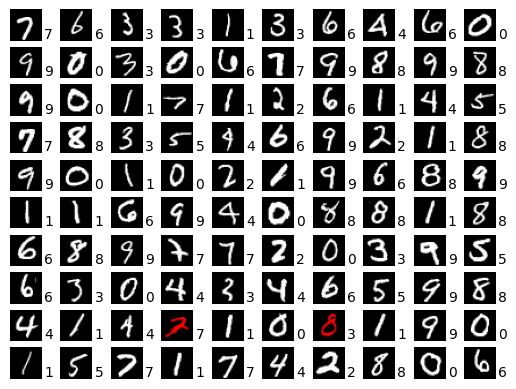

Epoch 4, Step 0: Training loss - 3.0291125774383545
Epoch 4, Step 100: Training loss - 6.620222091674805
Epoch 4, Step 200: Training loss - 3.0346293449401855
Epoch 4, Step 300: Training loss - 0.5922850966453552
Epoch 4, Step 400: Training loss - 0.8139390349388123
Epoch 4, Step 500: Training loss - 2.2724742889404297
Epoch 4, Step 600: Training loss - 0.2452085316181183
Epoch 4, Step 700: Training loss - 0.06759285181760788
Epoch 4, Step 800: Training loss - 6.978806018829346
Epoch 4, Step 900: Training loss - 0.653228759765625

Test set: Average loss: 0.0569, Accuracy: 9841/10000 (98.41%)



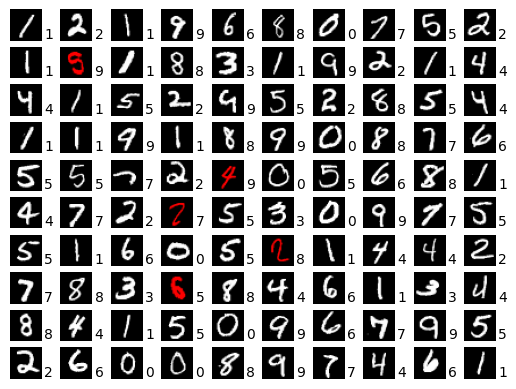

Epoch 5, Step 0: Training loss - 2.2142114639282227
Epoch 5, Step 100: Training loss - 1.0105412006378174
Epoch 5, Step 200: Training loss - 0.6045305132865906
Epoch 5, Step 300: Training loss - 3.793872117996216
Epoch 5, Step 400: Training loss - 0.1677369475364685
Epoch 5, Step 500: Training loss - 1.263322114944458
Epoch 5, Step 600: Training loss - 0.3552080988883972
Epoch 5, Step 700: Training loss - 0.3910806477069855
Epoch 5, Step 800: Training loss - 0.23821763694286346
Epoch 5, Step 900: Training loss - 6.357607841491699

Test set: Average loss: 0.0556, Accuracy: 9843/10000 (98.43%)



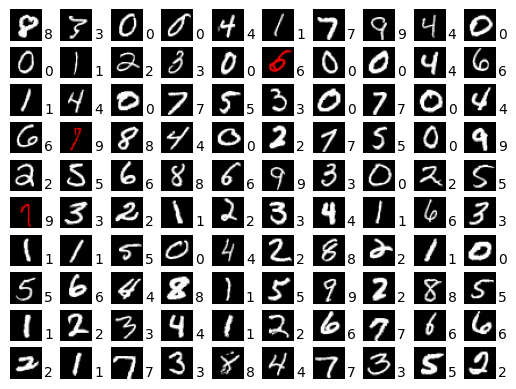

Epoch 6, Step 0: Training loss - 1.5679987668991089
Epoch 6, Step 100: Training loss - 0.39163872599601746
Epoch 6, Step 200: Training loss - 1.190144419670105
Epoch 6, Step 300: Training loss - 0.045412153005599976
Epoch 6, Step 400: Training loss - 0.4653572738170624
Epoch 6, Step 500: Training loss - 1.6894444227218628
Epoch 6, Step 600: Training loss - 0.7356722354888916
Epoch 6, Step 700: Training loss - 0.37191087007522583
Epoch 6, Step 800: Training loss - 4.170599460601807
Epoch 6, Step 900: Training loss - 0.2472972720861435

Test set: Average loss: 0.0562, Accuracy: 9849/10000 (98.49%)



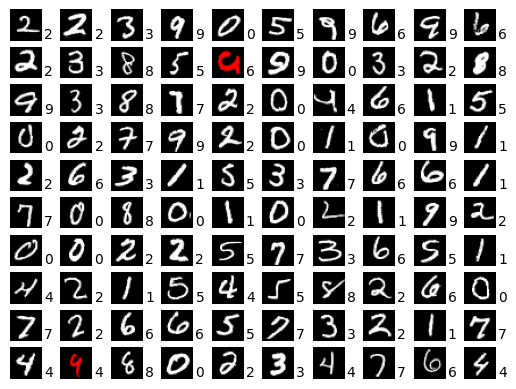

Epoch 7, Step 0: Training loss - 1.8995575904846191
Epoch 7, Step 100: Training loss - 3.190196990966797
Epoch 7, Step 200: Training loss - 0.2590334117412567
Epoch 7, Step 300: Training loss - 0.6394900679588318
Epoch 7, Step 400: Training loss - 0.1187569797039032
Epoch 7, Step 500: Training loss - 1.3127517700195312
Epoch 7, Step 600: Training loss - 0.0471588633954525
Epoch 7, Step 700: Training loss - 0.4113992154598236
Epoch 7, Step 800: Training loss - 5.34616756439209
Epoch 7, Step 900: Training loss - 2.0278115272521973

Test set: Average loss: 0.0581, Accuracy: 9847/10000 (98.47%)



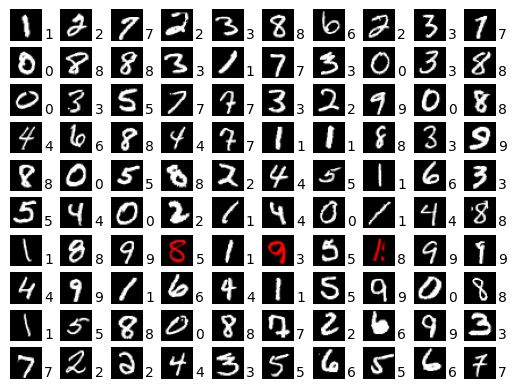

Epoch 8, Step 0: Training loss - 1.3837006092071533
Epoch 8, Step 100: Training loss - 0.037182629108428955
Epoch 8, Step 200: Training loss - 9.640894889831543
Epoch 8, Step 300: Training loss - 0.04190477728843689
Epoch 8, Step 400: Training loss - 0.5357299447059631
Epoch 8, Step 500: Training loss - 0.38661816716194153
Epoch 8, Step 600: Training loss - 0.3018518388271332
Epoch 8, Step 700: Training loss - 0.016569994390010834
Epoch 8, Step 800: Training loss - 1.5484256744384766
Epoch 8, Step 900: Training loss - 0.1819138079881668

Test set: Average loss: 0.0588, Accuracy: 9851/10000 (98.51%)



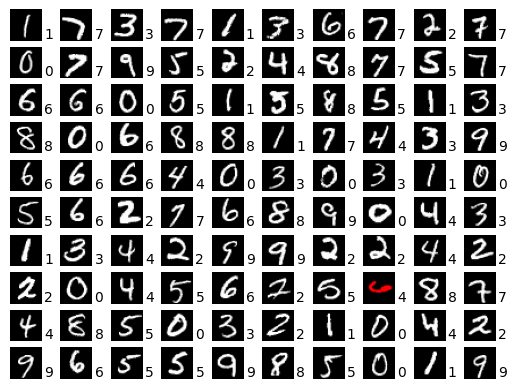

Epoch 9, Step 0: Training loss - 0.13626064360141754
Epoch 9, Step 100: Training loss - 0.3021795451641083
Epoch 9, Step 200: Training loss - 3.816944122314453
Epoch 9, Step 300: Training loss - 0.06368499249219894
Epoch 9, Step 400: Training loss - 0.02814924344420433
Epoch 9, Step 500: Training loss - 0.2024749219417572
Epoch 9, Step 600: Training loss - 0.40749749541282654
Epoch 9, Step 700: Training loss - 0.695952296257019
Epoch 9, Step 800: Training loss - 0.3361864686012268
Epoch 9, Step 900: Training loss - 2.140390634536743

Test set: Average loss: 0.0595, Accuracy: 9846/10000 (98.46%)



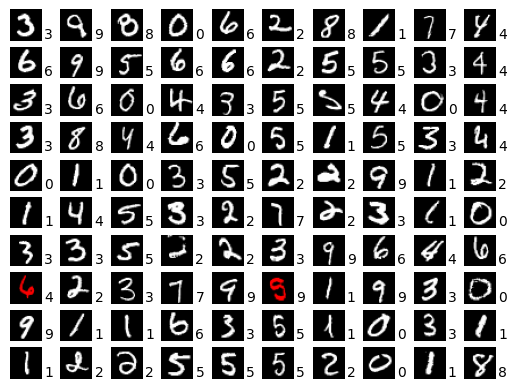

Epoch 10, Step 0: Training loss - 0.019101981073617935
Epoch 10, Step 100: Training loss - 1.011903166770935
Epoch 10, Step 200: Training loss - 0.02787746675312519
Epoch 10, Step 300: Training loss - 0.5488039255142212
Epoch 10, Step 400: Training loss - 0.1825675517320633
Epoch 10, Step 500: Training loss - 0.5400151610374451
Epoch 10, Step 600: Training loss - 0.1304699182510376
Epoch 10, Step 700: Training loss - 0.014377596788108349
Epoch 10, Step 800: Training loss - 0.4722844660282135
Epoch 10, Step 900: Training loss - 4.2854180335998535

Test set: Average loss: 0.0576, Accuracy: 9844/10000 (98.44%)



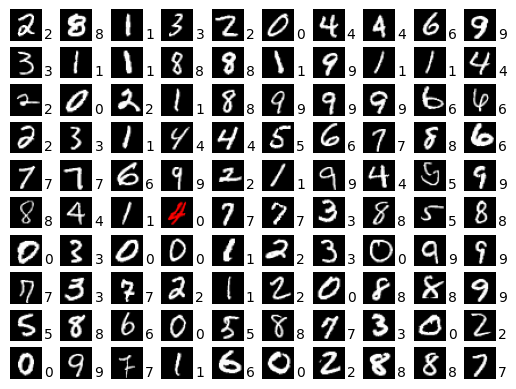

In [21]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### ConvNet 1

Epoch 1, Step 0: Training loss - 147.19061279296875
Epoch 1, Step 100: Training loss - 23.806413650512695
Epoch 1, Step 200: Training loss - 10.994236946105957
Epoch 1, Step 300: Training loss - 6.5742998123168945
Epoch 1, Step 400: Training loss - 10.44923210144043
Epoch 1, Step 500: Training loss - 4.161479949951172
Epoch 1, Step 600: Training loss - 4.325230121612549
Epoch 1, Step 700: Training loss - 0.2948707640171051
Epoch 1, Step 800: Training loss - 4.337102890014648
Epoch 1, Step 900: Training loss - 0.8562774658203125

Test set: Average loss: 0.0516, Accuracy: 9831/10000 (98.31%)



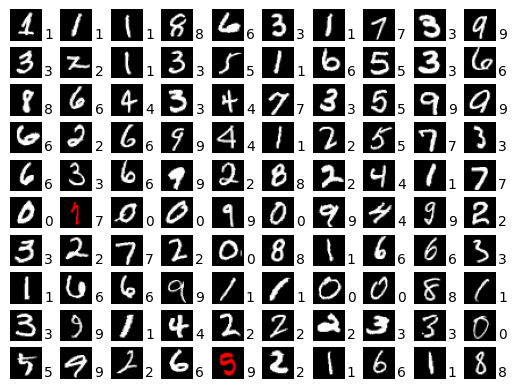

Epoch 2, Step 0: Training loss - 5.803577423095703
Epoch 2, Step 100: Training loss - 0.44724926352500916
Epoch 2, Step 200: Training loss - 3.370772361755371
Epoch 2, Step 300: Training loss - 1.67526376247406
Epoch 2, Step 400: Training loss - 4.663383483886719
Epoch 2, Step 500: Training loss - 1.7190505266189575
Epoch 2, Step 600: Training loss - 0.20778971910476685
Epoch 2, Step 700: Training loss - 2.1202330589294434
Epoch 2, Step 800: Training loss - 0.02504778280854225
Epoch 2, Step 900: Training loss - 3.6385600566864014

Test set: Average loss: 0.0361, Accuracy: 9891/10000 (98.91%)



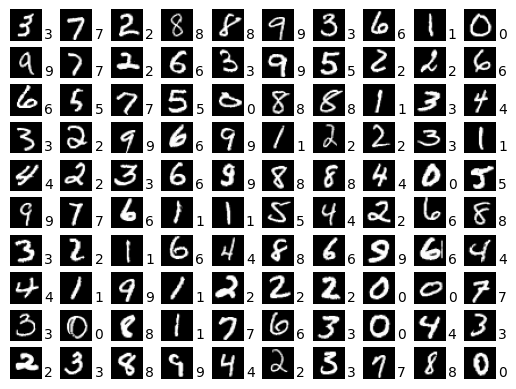

Epoch 3, Step 0: Training loss - 0.4662031829357147
Epoch 3, Step 100: Training loss - 0.17074809968471527
Epoch 3, Step 200: Training loss - 0.12454723566770554
Epoch 3, Step 300: Training loss - 0.06282084435224533
Epoch 3, Step 400: Training loss - 0.19219845533370972
Epoch 3, Step 500: Training loss - 0.563039243221283
Epoch 3, Step 600: Training loss - 0.0909341499209404
Epoch 3, Step 700: Training loss - 0.16223667562007904
Epoch 3, Step 800: Training loss - 0.07341044396162033
Epoch 3, Step 900: Training loss - 0.023455385118722916

Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)



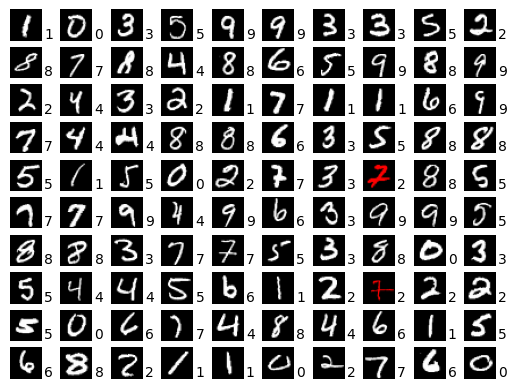

Epoch 4, Step 0: Training loss - 0.07598314434289932
Epoch 4, Step 100: Training loss - 0.4364699423313141
Epoch 4, Step 200: Training loss - 0.5305427312850952
Epoch 4, Step 300: Training loss - 0.21782590448856354
Epoch 4, Step 400: Training loss - 0.01882268115878105
Epoch 4, Step 500: Training loss - 0.02434385195374489
Epoch 4, Step 600: Training loss - 0.027043506503105164
Epoch 4, Step 700: Training loss - 0.9293965697288513
Epoch 4, Step 800: Training loss - 0.17042995989322662
Epoch 4, Step 900: Training loss - 0.17315202951431274

Test set: Average loss: 0.0338, Accuracy: 9907/10000 (99.07%)



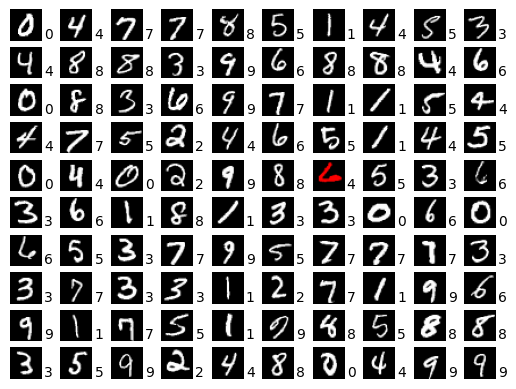

Epoch 5, Step 0: Training loss - 0.09944518655538559
Epoch 5, Step 100: Training loss - 0.02519989386200905
Epoch 5, Step 200: Training loss - 1.1392282247543335
Epoch 5, Step 300: Training loss - 0.10319408029317856
Epoch 5, Step 400: Training loss - 0.007251875940710306
Epoch 5, Step 500: Training loss - 6.106757640838623
Epoch 5, Step 600: Training loss - 0.0074958279728889465
Epoch 5, Step 700: Training loss - 0.005414531100541353
Epoch 5, Step 800: Training loss - 0.04174826294183731
Epoch 5, Step 900: Training loss - 0.0033855000510811806

Test set: Average loss: 0.0357, Accuracy: 9908/10000 (99.08%)



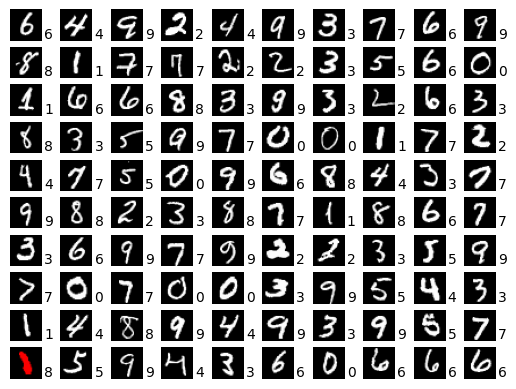

Epoch 6, Step 0: Training loss - 2.28368878364563
Epoch 6, Step 100: Training loss - 0.00040119816549122334
Epoch 6, Step 200: Training loss - 0.019911400973796844
Epoch 6, Step 300: Training loss - 0.01090233400464058
Epoch 6, Step 400: Training loss - 0.006274435203522444
Epoch 6, Step 500: Training loss - 0.0609387531876564
Epoch 6, Step 600: Training loss - 0.0001108631186070852
Epoch 6, Step 700: Training loss - 0.041042719036340714
Epoch 6, Step 800: Training loss - 0.00029227646882645786
Epoch 6, Step 900: Training loss - 0.0042349798604846

Test set: Average loss: 0.0387, Accuracy: 9905/10000 (99.05%)



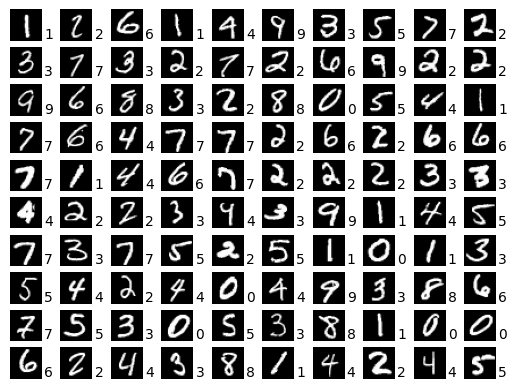

Epoch 7, Step 0: Training loss - 0.008344301953911781
Epoch 7, Step 100: Training loss - 0.008514140732586384
Epoch 7, Step 200: Training loss - 0.2692936658859253
Epoch 7, Step 300: Training loss - 0.0004839120083488524
Epoch 7, Step 400: Training loss - 0.012578664347529411
Epoch 7, Step 500: Training loss - 2.5949532985687256
Epoch 7, Step 600: Training loss - 0.014282485470175743
Epoch 7, Step 700: Training loss - 0.0027711172588169575
Epoch 7, Step 800: Training loss - 0.17702364921569824
Epoch 7, Step 900: Training loss - 0.002000493463128805

Test set: Average loss: 0.0404, Accuracy: 9910/10000 (99.10%)



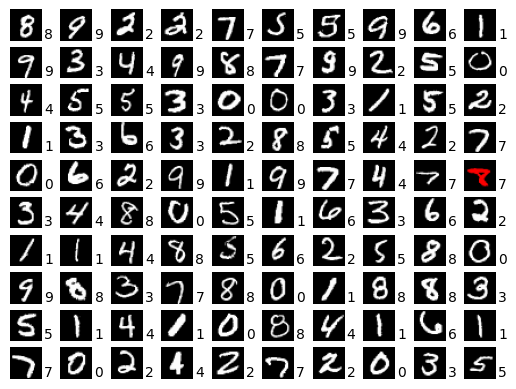

Epoch 8, Step 0: Training loss - 0.003137904219329357
Epoch 8, Step 100: Training loss - 0.0016279678093269467
Epoch 8, Step 200: Training loss - 0.0005793151794932783
Epoch 8, Step 300: Training loss - 0.008080750703811646
Epoch 8, Step 400: Training loss - 9.19094163691625e-05
Epoch 8, Step 500: Training loss - 0.0010285370517522097
Epoch 8, Step 600: Training loss - 1.3544011116027832
Epoch 8, Step 700: Training loss - 0.018953636288642883
Epoch 8, Step 800: Training loss - 0.006593832280486822
Epoch 8, Step 900: Training loss - 0.0006700843805447221

Test set: Average loss: 0.0425, Accuracy: 9904/10000 (99.04%)



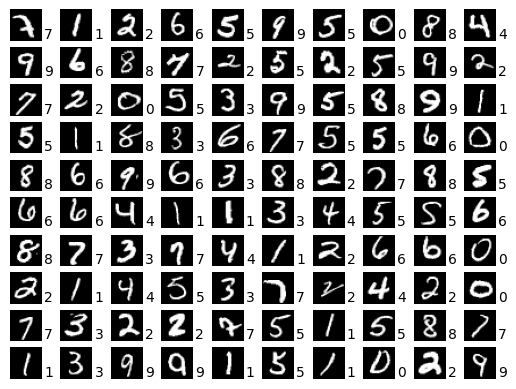

Epoch 9, Step 0: Training loss - 0.007268335670232773
Epoch 9, Step 100: Training loss - 0.0035737059079110622
Epoch 9, Step 200: Training loss - 0.005838887766003609
Epoch 9, Step 300: Training loss - 0.0030433081556111574
Epoch 9, Step 400: Training loss - 0.004783198237419128
Epoch 9, Step 500: Training loss - 0.010669498704373837
Epoch 9, Step 600: Training loss - 0.0023178132250905037
Epoch 9, Step 700: Training loss - 6.544528878293931e-05
Epoch 9, Step 800: Training loss - 0.03223155811429024
Epoch 9, Step 900: Training loss - 0.0018145479261875153

Test set: Average loss: 0.0439, Accuracy: 9908/10000 (99.08%)



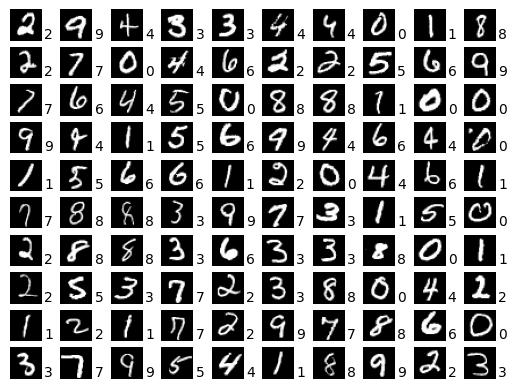

Epoch 10, Step 0: Training loss - 0.0016469714464619756
Epoch 10, Step 100: Training loss - 0.0008345777750946581
Epoch 10, Step 200: Training loss - 0.001170133356936276
Epoch 10, Step 300: Training loss - 0.00022624524717684835
Epoch 10, Step 400: Training loss - 0.003215990960597992
Epoch 10, Step 500: Training loss - 0.0043616630136966705
Epoch 10, Step 600: Training loss - 0.0022077488247305155
Epoch 10, Step 700: Training loss - 0.0006125764921307564
Epoch 10, Step 800: Training loss - 0.001462726853787899
Epoch 10, Step 900: Training loss - 0.00719246082007885

Test set: Average loss: 0.0448, Accuracy: 9904/10000 (99.04%)



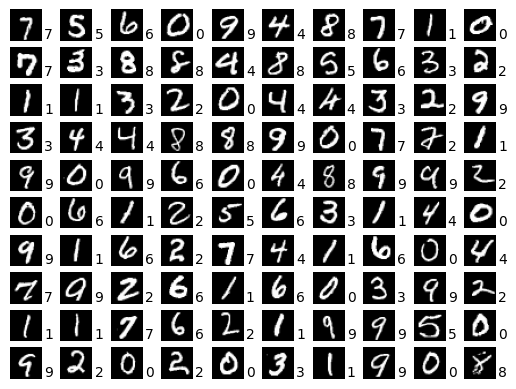

In [60]:

# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### ConvNet 2

Epoch 1, Step 0: Training loss - 156.03512573242188
Epoch 1, Step 100: Training loss - 5.443737983703613
Epoch 1, Step 200: Training loss - 1.5352787971496582
Epoch 1, Step 300: Training loss - 12.412835121154785
Epoch 1, Step 400: Training loss - 1.3714770078659058
Epoch 1, Step 500: Training loss - 3.1247217655181885
Epoch 1, Step 600: Training loss - 2.303288698196411
Epoch 1, Step 700: Training loss - 3.0203583240509033
Epoch 1, Step 800: Training loss - 1.0560486316680908
Epoch 1, Step 900: Training loss - 2.1330251693725586

Test set: Average loss: 0.0380, Accuracy: 9880/10000 (98.80%)



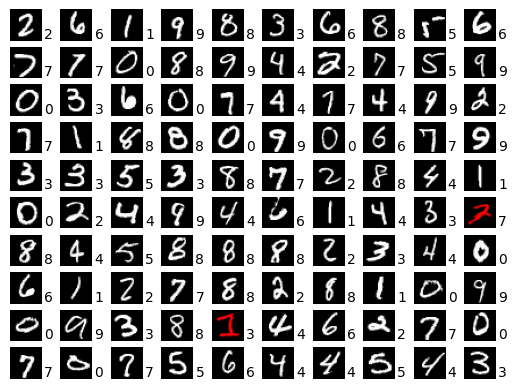

Epoch 2, Step 0: Training loss - 0.670326828956604
Epoch 2, Step 100: Training loss - 0.2360640913248062
Epoch 2, Step 200: Training loss - 7.688356876373291
Epoch 2, Step 300: Training loss - 1.2645412683486938
Epoch 2, Step 400: Training loss - 14.97654914855957
Epoch 2, Step 500: Training loss - 0.3354990780353546
Epoch 2, Step 600: Training loss - 0.4073861837387085
Epoch 2, Step 700: Training loss - 0.4525946378707886
Epoch 2, Step 800: Training loss - 0.3961142599582672
Epoch 2, Step 900: Training loss - 1.3804858922958374

Test set: Average loss: 0.0303, Accuracy: 9900/10000 (99.00%)



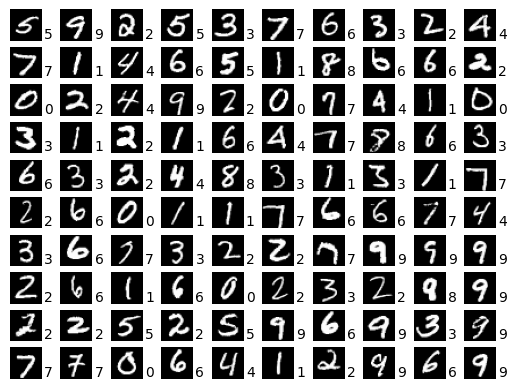

Epoch 3, Step 0: Training loss - 0.32434993982315063
Epoch 3, Step 100: Training loss - 1.19858717918396
Epoch 3, Step 200: Training loss - 0.14659978449344635
Epoch 3, Step 300: Training loss - 0.8975245952606201
Epoch 3, Step 400: Training loss - 0.6919984817504883
Epoch 3, Step 500: Training loss - 8.222249031066895
Epoch 3, Step 600: Training loss - 0.5135049819946289
Epoch 3, Step 700: Training loss - 0.4291996359825134
Epoch 3, Step 800: Training loss - 1.8247750997543335
Epoch 3, Step 900: Training loss - 0.3359255790710449

Test set: Average loss: 0.0272, Accuracy: 9911/10000 (99.11%)



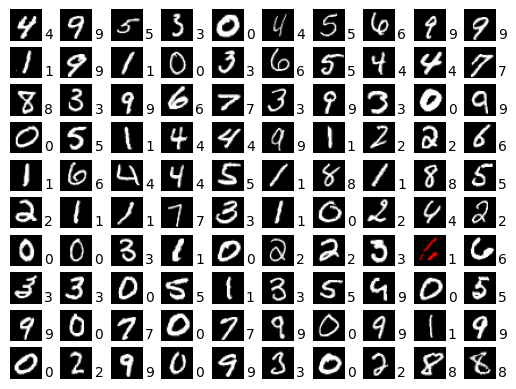

Epoch 4, Step 0: Training loss - 0.04370952025055885
Epoch 4, Step 100: Training loss - 0.050622742623090744
Epoch 4, Step 200: Training loss - 0.1054261326789856
Epoch 4, Step 300: Training loss - 0.01163460686802864
Epoch 4, Step 400: Training loss - 0.16163954138755798
Epoch 4, Step 500: Training loss - 0.15592126548290253
Epoch 4, Step 600: Training loss - 0.08135935664176941
Epoch 4, Step 700: Training loss - 0.15472251176834106
Epoch 4, Step 800: Training loss - 0.46345171332359314
Epoch 4, Step 900: Training loss - 0.6496186256408691

Test set: Average loss: 0.0313, Accuracy: 9902/10000 (99.02%)



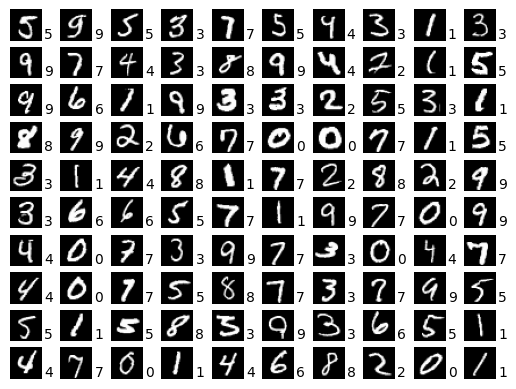

Epoch 5, Step 0: Training loss - 0.08950676769018173
Epoch 5, Step 100: Training loss - 0.09289319813251495
Epoch 5, Step 200: Training loss - 0.05106335133314133
Epoch 5, Step 300: Training loss - 0.044284798204898834
Epoch 5, Step 400: Training loss - 0.035294875502586365
Epoch 5, Step 500: Training loss - 0.013164310716092587
Epoch 5, Step 600: Training loss - 0.19536392390727997
Epoch 5, Step 700: Training loss - 0.5999784469604492
Epoch 5, Step 800: Training loss - 0.28054454922676086
Epoch 5, Step 900: Training loss - 0.09485718607902527

Test set: Average loss: 0.0315, Accuracy: 9905/10000 (99.05%)



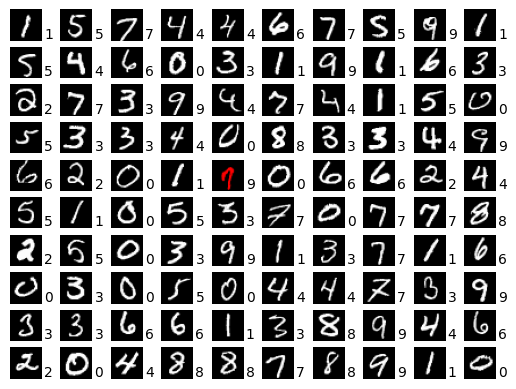

Epoch 6, Step 0: Training loss - 0.003276150906458497
Epoch 6, Step 100: Training loss - 0.03192901611328125
Epoch 6, Step 200: Training loss - 0.036539845168590546
Epoch 6, Step 300: Training loss - 0.021855732426047325
Epoch 6, Step 400: Training loss - 0.03227020055055618
Epoch 6, Step 500: Training loss - 0.00875661801546812
Epoch 6, Step 600: Training loss - 0.48553237318992615
Epoch 6, Step 700: Training loss - 0.002897257450968027
Epoch 6, Step 800: Training loss - 4.36755895614624
Epoch 6, Step 900: Training loss - 0.01381220668554306

Test set: Average loss: 0.0325, Accuracy: 9903/10000 (99.03%)



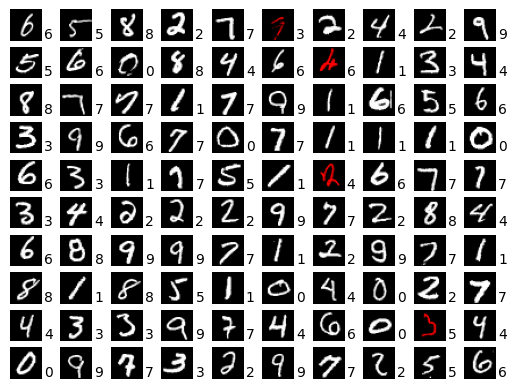

Epoch 7, Step 0: Training loss - 0.03551705181598663
Epoch 7, Step 100: Training loss - 0.027388306334614754
Epoch 7, Step 200: Training loss - 0.004321044776588678
Epoch 7, Step 300: Training loss - 0.008745644241571426
Epoch 7, Step 400: Training loss - 0.011986522004008293
Epoch 7, Step 500: Training loss - 0.015878010541200638
Epoch 7, Step 600: Training loss - 0.044580280780792236
Epoch 7, Step 700: Training loss - 0.19800473749637604
Epoch 7, Step 800: Training loss - 0.19221627712249756
Epoch 7, Step 900: Training loss - 0.1533161848783493

Test set: Average loss: 0.0334, Accuracy: 9905/10000 (99.05%)



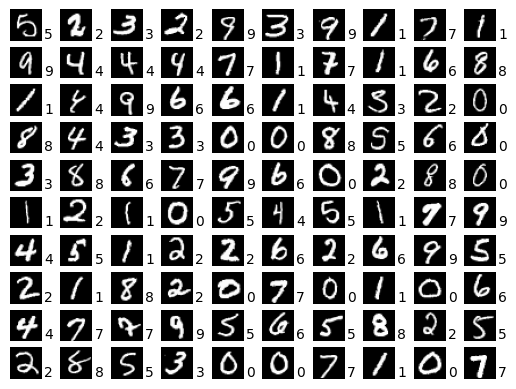

Epoch 8, Step 0: Training loss - 0.016944628208875656
Epoch 8, Step 100: Training loss - 0.01110114436596632
Epoch 8, Step 200: Training loss - 0.03382561355829239
Epoch 8, Step 300: Training loss - 0.04433925449848175
Epoch 8, Step 400: Training loss - 0.008600250817835331
Epoch 8, Step 500: Training loss - 0.009073948487639427
Epoch 8, Step 600: Training loss - 0.01771697774529457
Epoch 8, Step 700: Training loss - 0.012090984731912613
Epoch 8, Step 800: Training loss - 0.01013222336769104
Epoch 8, Step 900: Training loss - 0.006415858864784241

Test set: Average loss: 0.0337, Accuracy: 9901/10000 (99.01%)



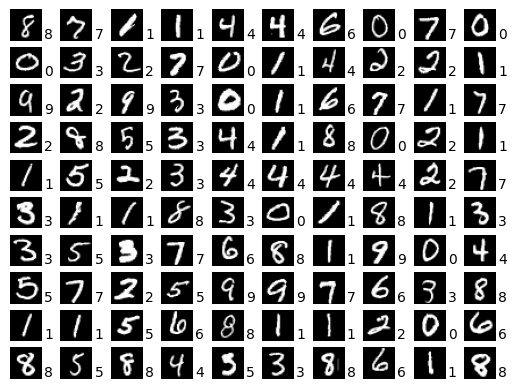

Epoch 9, Step 0: Training loss - 0.11196013540029526
Epoch 9, Step 100: Training loss - 0.20536042749881744
Epoch 9, Step 200: Training loss - 0.004946023225784302
Epoch 9, Step 300: Training loss - 0.0038886188995093107
Epoch 9, Step 400: Training loss - 0.025656476616859436
Epoch 9, Step 500: Training loss - 0.0038825601805001497
Epoch 9, Step 600: Training loss - 0.008315769955515862
Epoch 9, Step 700: Training loss - 0.6703049540519714
Epoch 9, Step 800: Training loss - 0.003373916493728757
Epoch 9, Step 900: Training loss - 0.024592142552137375

Test set: Average loss: 0.0347, Accuracy: 9901/10000 (99.01%)



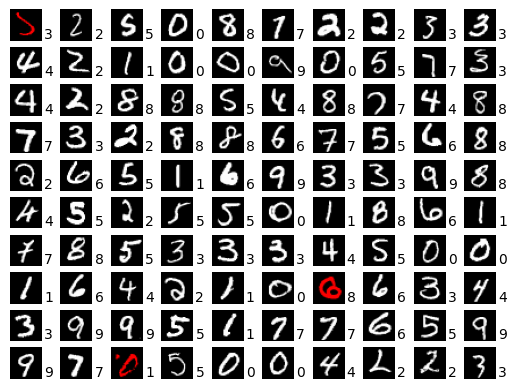

Epoch 10, Step 0: Training loss - 0.00928203109651804
Epoch 10, Step 100: Training loss - 0.05393629148602486
Epoch 10, Step 200: Training loss - 0.00842873752117157
Epoch 10, Step 300: Training loss - 0.018180275335907936
Epoch 10, Step 400: Training loss - 0.0028295163065195084
Epoch 10, Step 500: Training loss - 0.02010476402938366
Epoch 10, Step 600: Training loss - 0.9368962645530701
Epoch 10, Step 700: Training loss - 0.008562266826629639
Epoch 10, Step 800: Training loss - 0.03908143937587738
Epoch 10, Step 900: Training loss - 0.0066476608626544476

Test set: Average loss: 0.0349, Accuracy: 9900/10000 (99.00%)



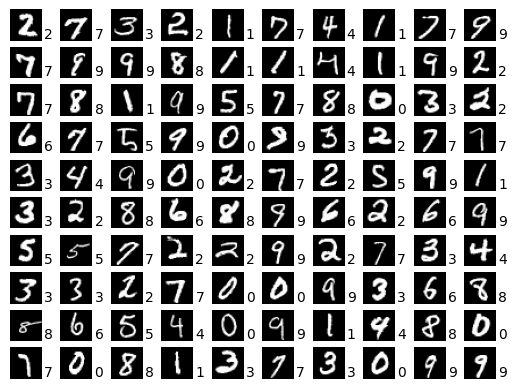

In [61]:

# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

### ConvNet 3

Epoch 1, Step 0: Training loss - 148.5602569580078
Epoch 1, Step 100: Training loss - 5.244757175445557
Epoch 1, Step 200: Training loss - 8.631754875183105
Epoch 1, Step 300: Training loss - 2.862461566925049
Epoch 1, Step 400: Training loss - 4.130348205566406
Epoch 1, Step 500: Training loss - 1.1766679286956787
Epoch 1, Step 600: Training loss - 0.5928744077682495
Epoch 1, Step 700: Training loss - 7.139865875244141
Epoch 1, Step 800: Training loss - 0.19154679775238037
Epoch 1, Step 900: Training loss - 1.4961823225021362

Test set: Average loss: 0.0369, Accuracy: 9879/10000 (98.79%)



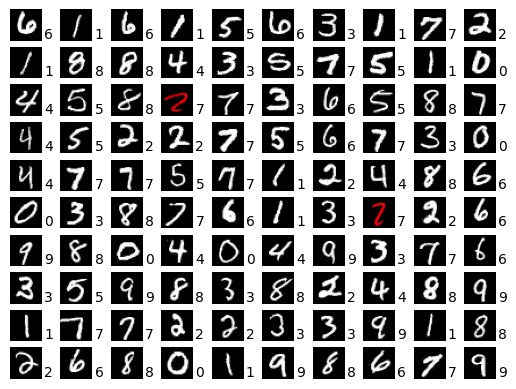

Epoch 2, Step 0: Training loss - 4.304869651794434
Epoch 2, Step 100: Training loss - 0.10007380694150925
Epoch 2, Step 200: Training loss - 0.4237160086631775
Epoch 2, Step 300: Training loss - 0.10305386036634445
Epoch 2, Step 400: Training loss - 0.9192706346511841
Epoch 2, Step 500: Training loss - 11.405684471130371
Epoch 2, Step 600: Training loss - 0.42136693000793457
Epoch 2, Step 700: Training loss - 0.1556817591190338
Epoch 2, Step 800: Training loss - 0.8824480772018433
Epoch 2, Step 900: Training loss - 1.1060222387313843

Test set: Average loss: 0.0255, Accuracy: 9910/10000 (99.10%)



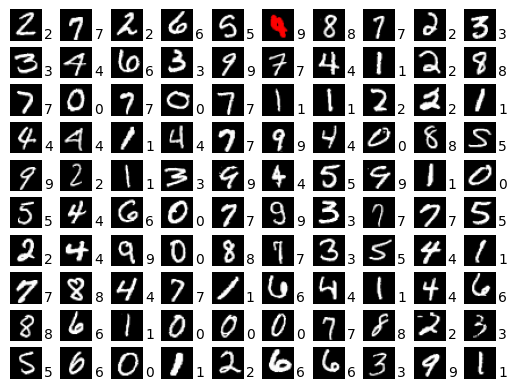

Epoch 3, Step 0: Training loss - 0.05679091811180115
Epoch 3, Step 100: Training loss - 0.10468769818544388
Epoch 3, Step 200: Training loss - 1.5491323471069336
Epoch 3, Step 300: Training loss - 0.21184299886226654
Epoch 3, Step 400: Training loss - 0.32655367255210876
Epoch 3, Step 500: Training loss - 0.7690843343734741
Epoch 3, Step 600: Training loss - 4.244899272918701
Epoch 3, Step 700: Training loss - 0.06643154472112656
Epoch 3, Step 800: Training loss - 0.765394926071167
Epoch 3, Step 900: Training loss - 0.8368712663650513

Test set: Average loss: 0.0296, Accuracy: 9898/10000 (98.98%)



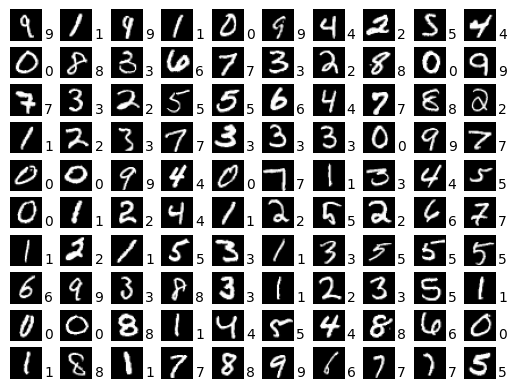

Epoch 4, Step 0: Training loss - 0.3912786841392517
Epoch 4, Step 100: Training loss - 0.025065923109650612
Epoch 4, Step 200: Training loss - 0.019078269600868225
Epoch 4, Step 300: Training loss - 0.2666282057762146
Epoch 4, Step 400: Training loss - 0.07265279442071915
Epoch 4, Step 500: Training loss - 0.08520256727933884
Epoch 4, Step 600: Training loss - 0.18337996304035187
Epoch 4, Step 700: Training loss - 0.18372970819473267
Epoch 4, Step 800: Training loss - 0.030793558806180954
Epoch 4, Step 900: Training loss - 0.3784485459327698

Test set: Average loss: 0.0251, Accuracy: 9910/10000 (99.10%)



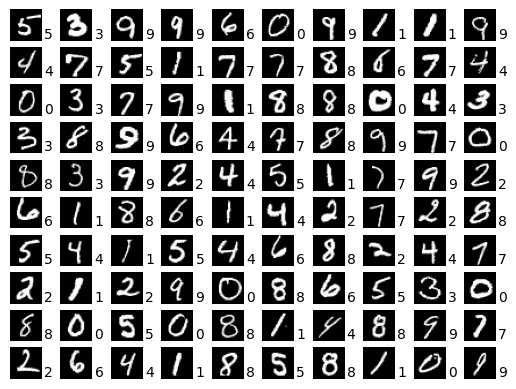

Epoch 5, Step 0: Training loss - 0.01492720190435648
Epoch 5, Step 100: Training loss - 0.05079770088195801
Epoch 5, Step 200: Training loss - 0.012613685801625252
Epoch 5, Step 300: Training loss - 0.005712768528610468
Epoch 5, Step 400: Training loss - 0.07327275723218918
Epoch 5, Step 500: Training loss - 0.552535891532898
Epoch 5, Step 600: Training loss - 1.4603537321090698
Epoch 5, Step 700: Training loss - 0.026701953262090683
Epoch 5, Step 800: Training loss - 0.011770089156925678
Epoch 5, Step 900: Training loss - 0.09808804839849472

Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)



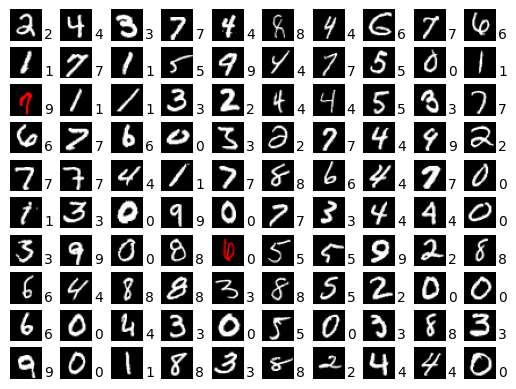

Epoch 6, Step 0: Training loss - 0.06036771833896637
Epoch 6, Step 100: Training loss - 0.0838814228773117
Epoch 6, Step 200: Training loss - 0.0043421839363873005
Epoch 6, Step 300: Training loss - 0.04765051603317261
Epoch 6, Step 400: Training loss - 0.12066447734832764
Epoch 6, Step 500: Training loss - 0.11775185912847519
Epoch 6, Step 600: Training loss - 0.1402151733636856
Epoch 6, Step 700: Training loss - 0.09976226836442947
Epoch 6, Step 800: Training loss - 0.020769624039530754
Epoch 6, Step 900: Training loss - 0.004583986476063728

Test set: Average loss: 0.0274, Accuracy: 9910/10000 (99.10%)



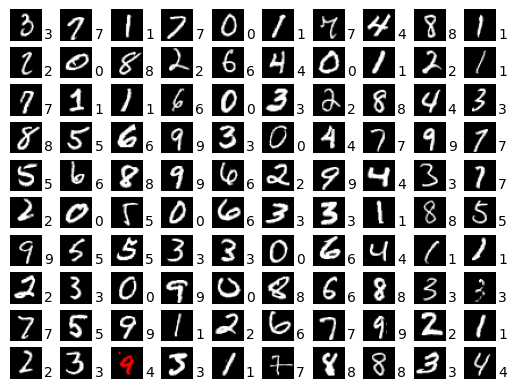

Epoch 7, Step 0: Training loss - 0.015872664749622345
Epoch 7, Step 100: Training loss - 0.014022283256053925
Epoch 7, Step 200: Training loss - 0.05135443061590195
Epoch 7, Step 300: Training loss - 0.006952165625989437
Epoch 7, Step 400: Training loss - 0.010613719932734966
Epoch 7, Step 500: Training loss - 0.06433892250061035
Epoch 7, Step 600: Training loss - 0.015307595953345299
Epoch 7, Step 700: Training loss - 0.016909556463360786
Epoch 7, Step 800: Training loss - 0.0027650361880660057
Epoch 7, Step 900: Training loss - 0.11898496747016907

Test set: Average loss: 0.0272, Accuracy: 9909/10000 (99.09%)



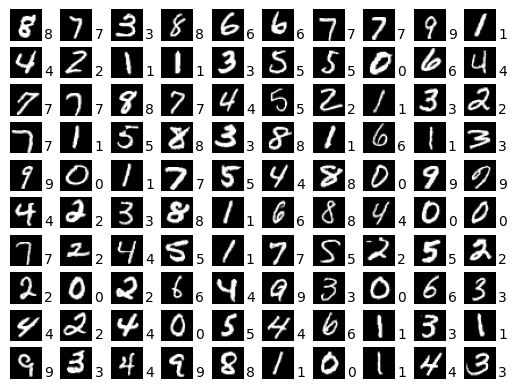

Epoch 8, Step 0: Training loss - 0.0416785404086113
Epoch 8, Step 100: Training loss - 0.009755529463291168
Epoch 8, Step 200: Training loss - 0.00878987181931734
Epoch 8, Step 300: Training loss - 0.0031297169625759125
Epoch 8, Step 400: Training loss - 0.02443573996424675
Epoch 8, Step 500: Training loss - 0.05196100473403931
Epoch 8, Step 600: Training loss - 0.13139985501766205
Epoch 8, Step 700: Training loss - 0.026040954515337944
Epoch 8, Step 800: Training loss - 0.004072466865181923
Epoch 8, Step 900: Training loss - 0.012397095561027527

Test set: Average loss: 0.0275, Accuracy: 9909/10000 (99.09%)



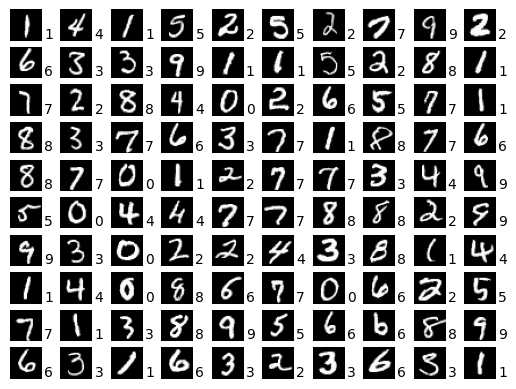

Epoch 9, Step 0: Training loss - 0.02559482865035534
Epoch 9, Step 100: Training loss - 0.009756199084222317
Epoch 9, Step 200: Training loss - 0.020874153822660446
Epoch 9, Step 300: Training loss - 0.0026823431253433228
Epoch 9, Step 400: Training loss - 0.10345257818698883
Epoch 9, Step 500: Training loss - 0.017193743959069252
Epoch 9, Step 600: Training loss - 0.005654024891555309
Epoch 9, Step 700: Training loss - 0.007947548292577267
Epoch 9, Step 800: Training loss - 0.0026493545155972242
Epoch 9, Step 900: Training loss - 0.08191236853599548

Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)



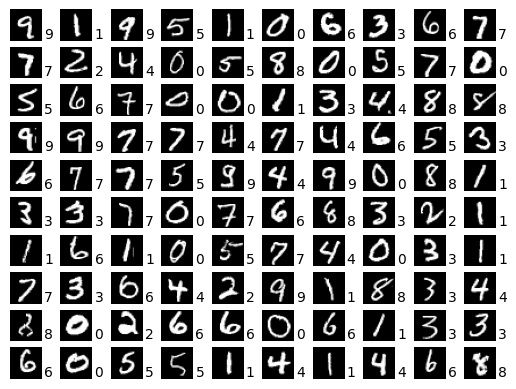

Epoch 10, Step 0: Training loss - 0.046678245067596436
Epoch 10, Step 100: Training loss - 0.0038949723821133375
Epoch 10, Step 200: Training loss - 0.00600849837064743
Epoch 10, Step 300: Training loss - 0.005807163193821907
Epoch 10, Step 400: Training loss - 0.006991170346736908
Epoch 10, Step 500: Training loss - 0.008598527871072292
Epoch 10, Step 600: Training loss - 0.8202495574951172
Epoch 10, Step 700: Training loss - 0.017512358725070953
Epoch 10, Step 800: Training loss - 0.005648267455399036
Epoch 10, Step 900: Training loss - 0.00892478134483099

Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)



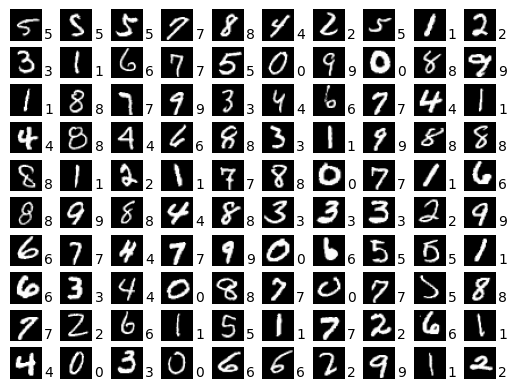

In [73]:

# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")